In [292]:
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [322]:
def get_killer_entry(player_name, session_id):
    '''
    Returns object "weapon" that were used to kill player defined by player_name in session defined by session_id
    '''
    
    # Get frame_number from one_player_state that corresponds to one player death in one session
    row = np.nonzero((one_player_state["stateflags"] == 53) & (one_player_state["sessionid"] == session_id))[0][0]
    entry = one_player_state.iloc[row]
    frame_number = entry["framenumber"]
    
    # Get row from game_frame that corresponds to the frame
    row = np.nonzero((game_frame["sessionid"] == session_id) & (game_frame["framenumber"] == frame_number))[0][0]
    json_entry_players = json.loads(game_frame.iloc[row]["players"])
    
    # Define the killer
    entry_killer = None
    for player_info in json_entry_players:
        if (player_info["state"]["state"]["stateflags"] // 2 % 2 == 1):
            entry_killer = player_info
    if entry_killer == None:
        return -1
    
    # Get killer's weapon
    #killer_weapon_id = entry_killer["state"]["state"]["weapon_id"]
    #killer_weapon_name = weapon_desc[weapon_desc["id"] == killer_weapon_id]["name"]
    
    # Return JSON entry with a killer
    return entry_killer

In [335]:
def get_basic_stats(player_name):
    '''
    Get some basic statistics
    '''
    
    # Session duration, accuracy, kill distance
    print("--- Player's name:", player_name, "---")
    print("Average session duration:\t", np.average(one_player_session["session_duration_seconds"]))
    print("Average accuracy:\t\t",
          np.average(one_player_session.iloc[np.nonzero(one_player_session["accuracy"])]["accuracy"]))
    print("Average kill distance:\t\t",
          np.average(one_player_session.iloc[np.nonzero(one_player_session["average_kill_distance"])]["average_kill_distance"]))

    # Get sessions where player died
    session_ids_player_died = np.asarray(one_player_state[one_player_state["stateflags"] == 53]["sessionid"])
    # Get weapons by which player was killed
    weapons = []
    for session_id in session_ids_player_died:
        killer_entry = get_killer_entry(player_name, session_id)
        if killer_entry == -1:
            weapons.append(-1)
        else:
            weapon_id = killer_entry["state"]["state"]["weapon_id"]
            weapon_name = weapon_desc[weapon_desc["id"] == weapon_id]["name"].iloc[0]
            weapons.append(weapon_name)

    print("In last sessions you was killed by following weapons:", weapons)

In [348]:
def get_graphs(player_name, step):
    '''
    Build graphs representing dynamics of player progress
    '''
    
    # Dynamics
    rows = one_player_session.shape[0]
    print("Total sessions:", rows)
    point_avg_rows = rows // step

    # Average session duration averaged over 'step' sessions
    average_session_duration = np.zeros(point_avg_rows)

    for i in range(point_avg_rows):
        average_session_duration[i] = (np.average(one_player_session["session_duration_seconds"].iloc[:(i+1)*step]))

    plt.plot(average_session_duration, marker='.')

In [294]:
filenames = [
    "game_frame.csv",
    "game_session.csv",
    "player_session.csv",
    "player_state.csv",
    "weapon_desc.csv"
]
game_frame = pd.read_csv(filenames[0])
game_session = pd.read_csv(filenames[1])
player_session = pd.read_csv(filenames[2])
player_state = pd.read_csv(filenames[3])
weapon_desc = pd.read_csv(filenames[4])

In [271]:
game_frame.head(3)

,gameid,sessionid,framenumber,frametime_ms,players,events
0,185,6300479610403288849,6198,438,"[{""state"": {""team_id"": 0, ""state"": {""health"": ...",NaN
1,185,6300479610403288849,6286,2754,"[{""state"": {""team_id"": 0, ""state"": {""health"": ...",NaN
2,185,6300479610403288849,6306,626,"[{""state"": {""team_id"": 0, ""state"": {""health"": ...",NaN


In [272]:
game_session.head(3)

,gameid,sessionid,server_ip,server_name,time_started
0,185,6300479610403288849,45.35.0.0,GameSession,1542247623
1,185,4959622521747852516,162.244.0.0,GameSession,1542257137
2,185,4959622521747980894,162.244.0.0,GameSession,1542257952


In [273]:
player_session.head(3)

,gameid,playerguid,sessionid,playername,session_duration_seconds,kills,deaths,longest_kill_streak,average_kill_distance,shortest_kill_distance,longest_kill_distance,accuracy
0,185,David_Franco,6300479610403288849,NaN,107,0,0,0,0.000000,0.000000,0.000000,0.0
1,185,Cassandra_Moran,6300479610403288849,NaN,403,0,1,0,0.000000,0.000000,0.000000,0.0
2,185,Jason_Hale,6300479610403288849,NaN,403,2,1,2,1992.689209,1365.352295,2620.026123,50.0


In [274]:
player_state.head(3)

,gameid,sessionid,playerguid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
0,185,6300479610403288849,Michael_Bowman,6198,438,-124106.164062,-2741.320557,2253.628174,-0.993201,0.000780,-0.006666,-0.116221,0,2,90,0,11
1,185,6300479610403288849,Summer_Mahoney,6286,2754,-120610.898438,-1826.606567,2253.628174,-0.117604,0.002380,0.000282,0.993058,0,2,90,0,11
2,185,6300479610403288849,Michael_Bowman,6306,626,-124106.164062,-2741.320557,2253.628174,-0.993245,0.000777,-0.006666,-0.115840,0,2,90,0,11


In [275]:
weapon_desc.head(5)

,id,name
0,1,CampFire
1,2,Armor
2,3,WoodRessource
3,4,LeatherRessource
4,5,ElectronicRessource


# Recent sessions

**Take some info for specific player from recent sessions**

In [295]:
# Choose player name
player_name = "Beginner"
#player_name = "Intermediate"
#sessions_nr = 10
# Take rows from tables which are specific to this player
one_player_session = player_session[player_session["playerguid"] == player_name]
one_player_state = player_state[player_state["playerguid"] == player_name]
# Sort by session order
one_player_session = one_player_session.sort_values("sessionid")
one_player_state = one_player_state.sort_values(["sessionid", "framenumber"])

one_player_session.head(5)

,gameid,playerguid,sessionid,playername,session_duration_seconds,kills,deaths,longest_kill_streak,average_kill_distance,shortest_kill_distance,longest_kill_distance,accuracy
89,185,Beginner,2009668275064032533,NaN,1257,2,1,2,201.406769,126.431015,276.382538,50.0
102,185,Beginner,2009668275099974430,NaN,119,0,1,0,0.000000,0.000000,0.000000,0.0
172,185,Beginner,2009668275102291847,NaN,472,1,1,1,367.841675,367.841675,367.841675,40.0
52,185,Beginner,2687592411347818415,NaN,282,0,1,0,0.000000,0.000000,0.000000,0.0
222,185,Beginner,2687592411391066647,NaN,471,0,1,0,0.000000,0.000000,0.000000,0.0


In [296]:
one_player_state.head(5)

,gameid,sessionid,playerguid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
392247,185,2009668275064032533,Beginner,2714,13586,-121005.953125,-1381.163086,2253.628174,0.567612,0.014995,0.010341,-0.823094,0,2,90,0,14
392428,185,2009668275064032533,Beginner,2716,61,-121006.148438,-1382.794800,2253.628174,0.566073,0.015014,0.010313,-0.824154,0,0,90,0,14
392536,185,2009668275064032533,Beginner,2760,1377,-121156.695312,-1505.051025,2253.628174,0.584237,0.013693,0.009859,-0.811407,0,2,90,0,14
392538,185,2009668275064032533,Beginner,2762,62,-121166.132812,-1501.733643,2253.628174,0.567140,0.014922,0.010278,-0.823422,0,0,90,0,14
392778,185,2009668275064032533,Beginner,2824,1941,-121334.125000,-1870.606201,2253.628174,0.584200,0.016493,0.011876,-0.811355,0,2,90,0,14


In [297]:
state_arr = np.zeros([one_player_state.shape[0], 7])
one_player_state_flags = one_player_state["stateflags"]
state_arr[:,0] = 0
for i in np.arange(1,7):
    state_arr[:,i] = one_player_state_flags % 2
    one_player_state_flags = one_player_state_flags // 2
# Fill first column
for i in range(one_player_state["stateflags"].shape[0]):
    if np.sum(state_arr[i,:]) == 0:
        state_arr[i,0] = 1
state_arr[-3:]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1.]])

Get basic stats

In [336]:
get_basic_stats(player_name)

--- Player's name: Beginner ---
Average session duration:	 432.27272727272725
Average accuracy:		 46.666666666666664
Average kill distance:		 284.62422180175747
In last sessions you was killed by following weapons: [-1, -1, -1, -1, -1, -1, 'WarriorArrow', 'WarriorArrow']


Get graphs

Total sessions: 11


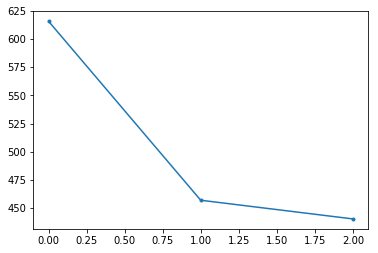

In [349]:
get_graphs(player_name, step=3)

# Player death

**Last frames before one player's death in one session**

In [350]:
# Take row id's when player died
rows_player_died = np.nonzero(one_player_state["stateflags"] == 53)[0]
# Take last 10 frames before death in last session (step 5)
one_player_state.iloc[rows_player_died[-1]-100: rows_player_died[-1]+1 : 1]

,gameid,sessionid,playerguid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
227970,185,6300479610382089742,Beginner,12106,35,-28285.933594,14867.668945,1379.628540,0.857732,0.060302,0.103454,-0.499956,0,1,90,300,11
227974,185,6300479610382089742,Beginner,12108,29,-28302.681641,14869.640625,1382.056396,0.859531,0.059677,0.103212,-0.496983,0,1,90,300,11
227981,185,6300479610382089742,Beginner,12110,31,-28305.193359,14872.334961,1382.105347,0.850935,0.063120,0.105160,-0.510752,0,1,90,300,11
227989,185,6300479610382089742,Beginner,12112,25,-28297.830078,14878.692383,1380.050537,0.863135,0.062677,0.110703,-0.488687,0,1,90,300,11
227997,185,6300479610382089742,Beginner,12114,32,-28281.810547,14889.375000,1376.026978,0.863216,0.062614,0.110629,-0.488569,0,1,90,300,11
228011,185,6300479610382089742,Beginner,12116,31,-28261.117188,14902.303711,1370.947998,0.860270,0.064085,0.111761,-0.493292,0,1,90,300,11
228003,185,6300479610382089742,Beginner,12118,31,-28231.863281,14919.708984,1363.885376,0.838217,0.069206,0.109509,-0.529726,0,1,90,300,11
228018,185,6300479610382089742,Beginner,12120,31,-28209.201172,14931.714844,1357.357788,0.807006,0.075299,0.105470,-0.576148,0,1,90,300,11
228024,185,6300479610382089742,Beginner,12122,31,-28177.783203,14945.204102,1347.756104,0.794075,0.077943,0.104245,-0.593719,0,1,90,300,11
228030,185,6300479610382089742,Beginner,12124,32,-28148.125000,14955.333984,1339.668335,0.725298,0.090461,0.097127,-0.675519,0,1,90,300,11


In [351]:
rows_player_died

array([13213, 18997, 21858, 30165, 31597, 35526, 41546, 42532])

In [300]:
# Get session id and frame number
session_id = one_player_state.iloc[rows_player_died[-1]]["sessionid"]
frame_number = one_player_state.iloc[rows_player_died[-1]]["framenumber"]
# Get game_frame row based on session and frame
row = np.nonzero((game_frame["sessionid"] == session_id) & (game_frame["framenumber"] == frame_number))[0][0]
json_entry_players = json.loads(game_frame.iloc[row]["players"])
#json_entry_players
get_killer_weapon(player_name, session_id)

'WarriorArrow'

**Graph of player movement**

In [305]:
session_nr = 2687592411388294992
p_nick_1 = ""
p_nick_2 = 
pos_XYZ_p1 = player_state[player_state["playerguid"] == "Michael_Bowman"][["posX", "posY", "posZ"]]
pos_XYZ_p2 = player_state[player_state["playerguid"] == "Intermediate"][["posX", "posY", "posZ"]]
plt.plot(pos_XYZ["posX"], pos_XYZ["posY"], '.')

SyntaxError: invalid syntax (<ipython-input-305-2a6e9a972e1f>, line 2)

In [33]:
player_state[player_state["playerguid"] == "Michael_Bowman"].describe()

,gameid,sessionid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
count,13208.0,1.320800e+04,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.0,13208.000000,13208.000000
mean,185.0,6.300480e+18,22761.564809,32.158465,32943.409843,-5896.536210,1385.969980,0.015321,0.057489,0.000185,-0.474202,3.655966,1.019836,90.0,542.169367,18.530209
std,0.0,0.000000e+00,6658.749055,41.885550,26593.133756,9985.873605,758.943378,0.656659,0.053129,0.074472,0.576265,10.180013,0.486573,0.0,135.157076,9.636169
min,185.0,6.300480e+18,6198.000000,23.000000,-125068.453125,-23735.675781,224.404724,-0.999754,0.000000,-0.449811,-0.999975,0.000000,0.000000,90.0,0.000000,11.000000
25%,185.0,6.300480e+18,17519.500000,30.000000,3040.343201,-11530.344238,909.264191,-0.634890,0.019064,-0.038867,-0.905680,0.000000,1.000000,90.0,600.000000,18.000000
50%,185.0,6.300480e+18,23870.000000,31.000000,39541.203125,-5064.280273,1190.993958,0.057678,0.044972,-0.004376,-0.682765,0.000000,1.000000,90.0,600.000000,18.000000
75%,185.0,6.300480e+18,28555.000000,31.000000,55491.761719,-2122.065186,1773.123932,0.634718,0.078187,0.032371,-0.304610,0.000000,1.000000,90.0,600.000000,18.000000
max,185.0,6.300480e+18,32650.000000,2790.000000,75303.812500,19358.673828,4963.423340,0.999960,0.385966,0.490187,0.999950,32.000000,52.000000,90.0,600.000000,106.000000


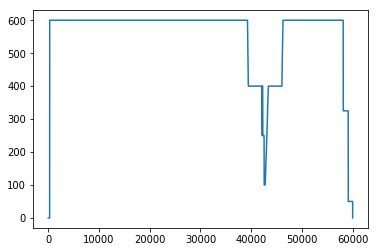

In [306]:
plt.plot(player_state[player_state["playerguid"] == "Michael_Bowman"]["health"])

In [307]:
player_state[player_state["playerguid"] == "Michael_Bowman"]["health"].shape

(13208,)

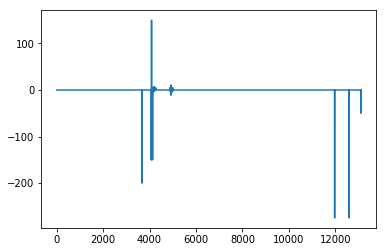

In [308]:
plt.plot(np.diff(player_state[player_state["playerguid"] == "Michael_Bowman"]["health"][100:]))

# Machine learning stuff